In [3]:
# This notebook runs through the below csv and compares every row with Landscan 
# data from the below tiff file, outputting correlation metrics 
# 
# 'Cell' --> 'Run All' 


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys
import time
import pickle
import numpy as np
import pandas as pd
from six.moves import xrange  
import tensorflow as tf
import gdal
from matplotlib import pyplot as plt
#import data_input as dataset
import geotiling as gt

In [4]:
df_annos = pd.read_csv("../data/annos_csv/state24_paths_density_labels_13k_Feb10.csv", index_col=0)
image_composite = gt.ImageComposite("../data/lspop2011.tif", 1)

In [5]:
# Example code for interacting with Landscan data 

lat, lon = 26.978193, 75.827624
col, row = image_composite.geoprops.lonlat2colrow(lon, lat)
# print(image_composite.geoprops.xOrigin)
# print(col, row)
x = image_composite.gdal_dataset.ReadAsArray(30699 - 200, 6842 - 200, 400, 400)
#print(x)

In [6]:
area = 1000000 
total_persons = sum(sum(x))
print(total_persons)
pop_density_landscan = total_persons *1.0/ area
print(pop_density_landscan)

50100208
50.100208


In [7]:
def get_class(pop_density):
    pop_density_log2 = np.log2(pop_density)
    pop_density_log2_int = np.minimum(np.maximum(np.floor(pop_density_log2),1),13).astype(int)
    pop_density_class = pop_density_log2_int - 1
    if pop_density_class < 3:
        return 3
    if pop_density_class > 9:
        return 9
    return pop_density_class

In [8]:
import math

# 1 degree on earth's surface is about 111km
# These photos have corner degree differences of about .2 degree 
# Thus, 1 image has edges about 22km long, showing an area of about 484 km^2 or 484000000 m ^2

def get_landscan_density(lat, long, area):
    #print(area)
    area_km2 = area/(10**6)
    size_box = int(area/(10**6)) + 1
    col, row = image_composite.geoprops.lonlat2colrow(lon, lat)
    x = image_composite.gdal_dataset.ReadAsArray(col - int(size_box/2), row - int(size_box/2), size_box, size_box)
    total_persons = sum(sum(x))
    pop_density_landscan = total_persons *1.0/ (size_box*size_box*math.cos(math.radians(lat)))
    return abs(pop_density_landscan)

lat1 = 33.6
lat2 = 8
lat3 = 0
print(abs(30.866666667*math.cos(math.radians(lat1))))
print(abs(30.866666667*math.cos(math.radians(lat2))))
print(abs(30.866666667*math.cos(math.radians(lat3))))

#In india, we range from 8 degrees north of the equator to about 33 degrees north of the equator
#This equates to a range of 1 arc second = 30.86 meters to 1 arc-second = 25.71 meters

25.70950229686271
30.566274388819895
30.866666667


In [9]:
def get_samples():
    samples = []
    for index, row in df_annos.iterrows():
        village_id = row.village_id
        pop_density = row.pop_density_log2
        samples.append((village_id, pop_density))
    return samples

def get_lat_long(village_id):
    long = df_annos.loc[df_annos['village_id'] == village_id].values[0][5]
    lat = df_annos.loc[df_annos['village_id'] == village_id].values[0][6]
    return (lat, long) 

def get_area(village_id):
    return df_annos.loc[df_annos['village_id'] == village_id].values[0][4]

In [10]:
sample_villages = get_samples()
# each tuple is (village_id, denstiy)  

In [22]:
density_landscan = []
density_census = []

count_trials = 0
correct_trials = 0
count_incorrect_trials = 0
difference = 0
count_per_class_landscan = [0,0,0,0,0,0,0,0,0,0,0,0,0]
count_per_class_census = [0,0,0,0,0,0,0,0,0,0,0,0,0]
differences = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
class_landscan = []
class_census = []
rmse = 0

# @JAY this is the main data loop - density_landscan are the input & density_census are corresponding labels
for (village_id, census_den) in sample_villages:
    if (count_trials % 1000 == 0 and count_trials > 0):
        print(count_trials)
    (lat, long) = get_lat_long(village_id)
    if ((math.isnan(lat)) or (math.isnan(long))):
        continue
    area = get_area(village_id)
    landscan_den = get_landscan_density(lat, long, area)
    
    
    # Code below is to collect metrics 
    density_landscan.append(landscan_den)
    density_census.append(census_den)
    
    
    rmse += ((landscan_den - census_den)*(landscan_den - census_den))
    count_trials += 1
    landscan_class = get_class(landscan_den)
    census_class = get_class(census_den)
    class_landscan.append(landscan_class)
    class_census.append(census_class)
    count_per_class_landscan[landscan_class] += 1
    count_per_class_census[census_class] += 1
    if (landscan_class == census_class):
        correct_trials += 1
    else:
        count_incorrect_trials += 1
        differences[(census_class - landscan_class) + 12] += 1
        difference += abs(census_class - landscan_class)



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [23]:
print("Correct predictions: ", correct_trials*1.0/count_trials)
print("Average Error: ", difference*1.0/count_incorrect_trials)
print("RMSE: ", math.sqrt(rmse/count_trials))
# print("-12 to 12 class difference counts", differences)

Correct predictions:  0.22065192614542967
Average Error:  1.91985960807
RMSE:  1453.7397996725804


<Container object of 13 artists>

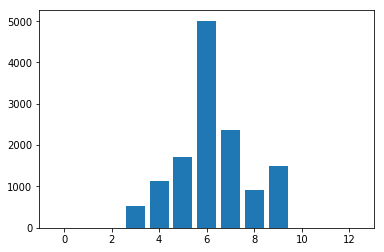

In [24]:
plt.bar(range(13), count_per_class_landscan)

<Container object of 13 artists>

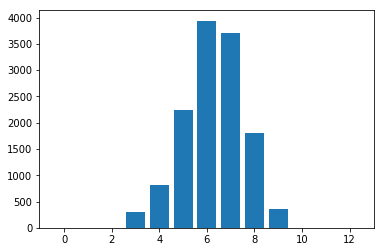

In [25]:
plt.bar(range(13), count_per_class_census)

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.plot(density_census, density_landscan,'ro')
# plt.show

In [16]:
# fig, ax = plt.subplots()
# fit = np.polyfit(density_census, density_landscan, deg=1)
# print(fit)
# ax.plot(density_census, fit[0] * density_census + fit[1], color='red')
# plt.scatter(density_census, density_landscan, marker='o');

In [17]:
# plt.scatter(density_census, density_landscan, marker='+');
# plt.plot(np.unique(density_census), np.poly1d(np.polyfit(density_census, density_landscan, 1))(np.unique(density_census)))
# plt.ylim(0, 2000)
# plt.xlim(0, 2000)

In [18]:
# idx = np.random.choice(np.arange(len(density_census)), 1000, replace=False)
# x_sample = np.take(density_census, idx)
# y_sample = np.take(density_landscan, idx)
# plt.scatter(x_sample, y_sample, marker='+');
# plt.plot(np.unique(x_sample), np.poly1d(np.polyfit(x_sample, y_sample, 1))(np.unique(x_sample)))
# plt.ylim(0, 2000)
# plt.xlim(0, 2000)

In [19]:
from sklearn.metrics import confusion_matrix
y_true = class_census
y_pred = class_landscan
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
[[   5   12   23  168   53   15   30]
 [  22   53   58  362  182   55   76]
 [  72  179  274  948  436  121  212]
 [ 183  392  555 1604  687  207  312]
 [ 168  320  526 1323  653  293  431]
 [  77  155  236  456  339  193  339]
 [  28   27   38  103   59   28   73]]
Normalized confusion matrix
[[ 0.02  0.04  0.08  0.55  0.17  0.05  0.1 ]
 [ 0.03  0.07  0.07  0.45  0.23  0.07  0.09]
 [ 0.03  0.08  0.12  0.42  0.19  0.05  0.09]
 [ 0.05  0.1   0.14  0.41  0.17  0.05  0.08]
 [ 0.05  0.09  0.14  0.36  0.18  0.08  0.12]
 [ 0.04  0.09  0.13  0.25  0.19  0.11  0.19]
 [ 0.08  0.08  0.11  0.29  0.17  0.08  0.21]]


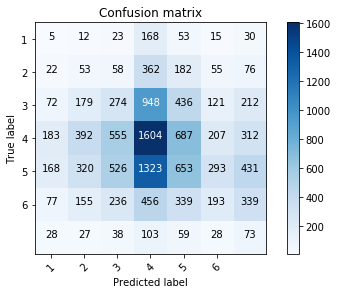

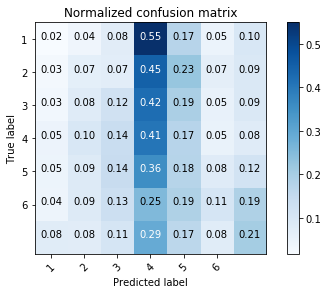

In [20]:
# This whole block is just to generate confusion matrices 



import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=range(1,7),
                      title='Confusion matrix')
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=range(1,7), normalize=True,
                      title='Normalized confusion matrix')

plt.show()